#### If yfinance is not already installed, uncomment the code block below, and run

In [ ]:
#!pip install yfinance


In [1]:

import yfinance as yf  
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
from datetime import datetime
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
now = datetime.now()
now = str(now.year)+"-"+str(now.month)+"-"+str(now.day)
import requests
import pandas as pd
import arrow
import datetime
import os


### MACD
https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


As its name implies, the MACD is all about the convergence and divergence of the two moving averages. Convergence occurs when the moving averages move towards each other. Divergence occurs when the moving averages move away from each other. The shorter moving average (12-day) is faster and responsible for most MACD movements. The longer moving average (26-day) is slower and less reactive to price changes in the underlying security.

The MACD line oscillates above and below the zero line, which is also known as the centerline. These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross. Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA. This means upside momentum is increasing. Negative MACD values indicate that the 12-day EMA is below the 26-day EMA. Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.

### Signal Line

Signal Line Crossovers
Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs when the MACD turns up and crosses above the signal line. A bearish crossover occurs when the MACD turns down and crosses below the signal line. Crossovers can last a few days or a few weeks, depending on the strength of the move.

Due diligence is required before relying on these common signals. Signal line crossovers at positive or negative extremes should be viewed with caution. Even though the MACD does not have upper and lower limits, chartists can estimate historical extremes with a simple visual assessment. It takes a strong move in the underlying security to push momentum to an extreme. Even though the move may continue, momentum is likely to slow and this will usually produce a signal line crossover at the extremities. Volatility in the underlying security can also increase the number of crossovers.

In [55]:


def get_quote_data_by_minute(symbol='SPCE', data_range='1d', data_interval='1m'):
    res = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()),verify=True)
    data = res.json()
    body = data['chart']['result'][0]    
    #dt = datetime.datetime
    dt = pd.Series(map(lambda x: arrow.get(x).datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas
    df=df.reset_index()
    return df

In [56]:
min_by_min = get_quote_data_by_minute(symbol='AMD',data_range='1d', data_interval='1m')

In [57]:
min_by_min

,Datetime,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2020-07-07 13:30:00,53.279999,53.500000,53.279999,53.419998,755351.0
1,2020-07-07 13:31:00,53.410000,53.560001,53.299999,53.530102,241605.0
2,2020-07-07 13:32:00,53.540001,53.720001,53.450001,53.720001,321341.0
3,2020-07-07 13:33:00,53.720001,53.735001,53.660000,53.681400,23601.0
4,2020-07-07 13:34:00,53.720001,53.723499,53.599998,53.630001,263618.0
5,2020-07-07 13:35:00,53.564999,53.645000,53.549999,53.639999,320067.0
6,2020-07-07 13:36:00,53.630001,53.630001,53.590000,53.610001,116959.0
7,2020-07-07 13:37:00,53.490002,53.496799,53.459999,53.480000,173579.0
8,2020-07-07 13:38:00,53.632000,53.660099,53.630001,53.650002,180805.0
9,2020-07-07 13:39:00,53.570000,53.584999,53.495098,53.570000,239487.0


In [58]:
def generate_stock_data(start_date,end_date,ticker):
    data = yf.download(ticker,start_date,end_date)
    
    data=data.reset_index()
    data=data.sort_values('Date')
    data=data[['Date','Open','Close','Volume','High','Low']]
    min_by_min = get_quote_data_by_minute(symbol=ticker,data_range='1d', data_interval='1m')
    min_by_min.columns=['Date','Open','High','Low','Close','Volume']
    update = min_by_min.loc[min_by_min.shape[0]-1]
    data=data.append(update)
    
    data['ticker']=ticker
    min_by_min.loc[min_by_min.shape[0]-1]
    #extract day of the week
    mapping = {0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    data['DOW'] = data['Date'].dt.dayofweek
    data['DOW_Mapped'] =data['DOW'].map(mapping)
    data['Date']=data['Date'].dt.date
    data['Date']=pd.to_datetime(data['Date'])
    
    
    #calculate 7 day moving average with open and close
    data['5Day_Moving_Average_Close'] = data['Close'].rolling(window=5).mean()
    data['5Day_Moving_Average_Open'] = data['Open'].rolling(window=5).mean()
    
    #long ma 
    data['26Day_Moving_Average_Close'] = data['Close'].ewm(span=26).mean()
    
    #mid ma 
    data['12Day_Moving_Average_Close'] = data['Close'].ewm(span=12).mean()
    
    
    #short ma
    data['9Day_Moving_Average_Close'] = data['Close'].ewm(span=9).mean()
    
    
    #MACD
    data['MACD']=data['12Day_Moving_Average_Close']-data['26Day_Moving_Average_Close']
    
    
    
    #average the MACD to derive the signal line
    data['signal'] = data['MACD'].ewm(span=9).mean()
    
    
    # difference the macd from the sinal line to find the acceleration histogram
    data['hist'] = data['MACD'] - data['signal']
    

    
    #lag variables 1 DAY
    data['Close_Shift_1']=    data['Close'].shift(1)
    data['Open_Shift_1']=    data['Open'].shift(1)
    
    #lag variables 1 WEEK
    data['Close_Shift_5']=    data['Close'].shift(5)
    data['Open_Shift_5']=    data['Open'].shift(5)
    
    
    #prev_day_hi_or_low close
    data['Prev_Day_Compare_Close'] = data['Close']-data['Close_Shift_1']
    data['Prev_Day_Growth_Close'] = (data['Close']-data['Close_Shift_1'])/data['Close_Shift_1']
    
    
    #prev_day_hi_or_low open
    data['Prev_Day_Compare_Open'] = data['Open']-data['Open_Shift_1']
    data['Prev_Day_Growth_Open'] = (data['Open']-data['Open_Shift_1'])/data['Open_Shift_1']
    
    
    
    
    #prev_day_hi_or_low close
    data['Prev_Week_Compare_Close'] = data['Close']-data['Close_Shift_5']
    data['Prev_Week_Growth_Close'] = (data['Close']-data['Close_Shift_5'])/data['Close_Shift_5']
    
    
    #prev_day_hi_or_low open
    data['Prev_Week_Compare_Open'] = data['Open']-data['Open_Shift_5']
    data['Prev_Week_Growth_Open'] = (data['Open']-data['Open_Shift_5'])/data['Open_Shift_5']
    
    
    
    
    data=data.iloc[5:]
    data

    
    return data




[*********************100%***********************]  1 of 1 completed


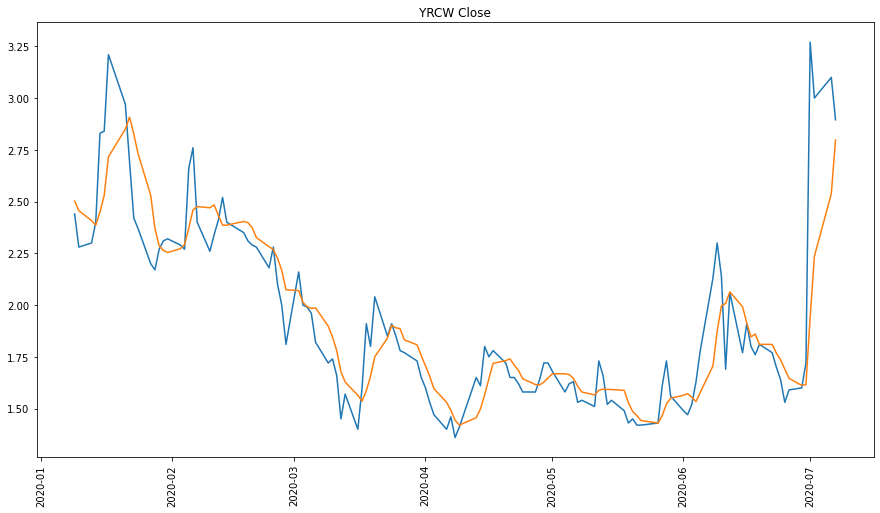

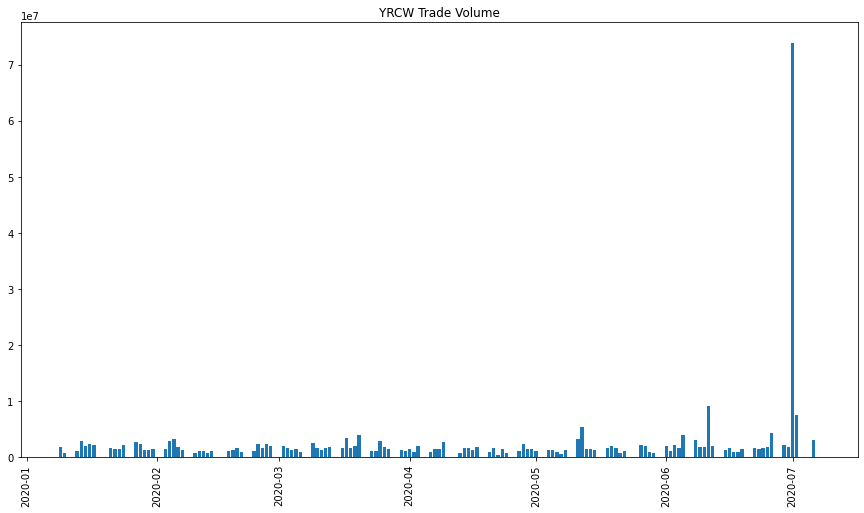

In [59]:
start = '2020-01-01'
ticker='YRCW'

SDOW = helper_functions.generate_stock_data(start,now,ticker)

plt.figure(figsize=(15,8))
plt.title('{} Close'.format(ticker))

plt.plot(SDOW['Date'],SDOW['Open'])

plt.plot(SDOW['Date'],SDOW['5Day_Moving_Average_Open'])

plt.xticks(rotation=90)
plt.show()
#----------------------------------------------

plt.figure(figsize=(15,8))
plt.title('{} Trade Volume'.format(ticker))


plt.bar(SDOW['Date'],SDOW['Volume'])

plt.xticks(rotation=90)
plt.show()


In [5]:
import datapackage

data_url = 'https://datahub.io/core/nasdaq-listings/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        NASDAQ = pd.read_csv(resource.descriptor['path'])
        

In [6]:
import tqdm
all_data = []

for sym in NASDAQ['Symbol']:
    try:
        curr = generate_stock_data(start,now,sym)
        all_data.append(curr)
    except:
        print('{} is delisted'.format(sym))

[*********************100%***********************]  1 of 1 completed
AAIT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAVL: No data found for this date range, symbol may be delisted
AAVL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ABAC: No data found for this date range, symbol may be delisted
ABAC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFCB: No data found for this date range, symbol may be delisted
AFCB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFFX: No data found for this date range, symbol may be delisted
AFFX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFOP: No data found for this date range, symbol may be delisted
AFOP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFSI: No data found for this date range, symbol may be delisted
AFSI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AGII: No data 

ANAD is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCB: No data found for this date range, symbol may be delisted
ANCB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCI: No data found for this date range, symbol may be delisted
ANCI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCX: No data found for this date range, symbol may be delisted
ANCX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATHN: No data found for this date range, symbol may be delisted
ATHN is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATML: No data found for this date range, symbol may be delisted
ATML is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATNY: No data found for this date range, symbol may be delisted
ATNY is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BEAV: No data found for this date range, symbol may be delisted
BEAV is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHBK: No data found for this date range, symbol may be delisted
BHBK is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%*********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTUI: No data found for this date range, symbol may be delisted
BTUI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BUR: No data found for this date range, symbol may be delisted
BUR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BVA: No data found for this date range, symbol may be delisted
BVA is delisted
[*********************100%***********************]  1 of 1 completed
BVSN 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBMX: No data found for this date range, symbol may be delisted
CBMX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBNJ: No data found for this date range, symbol may be delisted
CBNJ is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBRX: No data found for this date range, symbol may be delisted
CBRX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CHYR: No data found for this date range, symbol may be delisted
CHYR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIFC: No data found for this date range, symbol may be delisted
CIFC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIMT: No data found for this date range, symbol may be delisted
CIMT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CISAW: No data found, symbol may be delisted
CISAW is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CISG: No data found for this dat

COBZ is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- COCO: No data found for this date range, symbol may be delisted
COCO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- COOL: No data found for this date range, symbol may be delisted
COOL is delisted
[*****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTRL: No data found, symbol may be delisted
CTRL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTRP: No data found, symbol may be delisted
CTRP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTRX: No data found for this date range, symbol may be delisted
CTRX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTWS: No data found, symbol may be delisted
CTWS is delisted
[*********************100%*

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DMND: No data found for this date range, symbol may be delisted
DMND is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DNBF: No data found, symbol may be delisted
DNBF is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DOVR: No data found for this date range, symbol may be delisted
DOVR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DPRX: No data found for this date range, symbol may be delisted
DPRX

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EFUT: No data found for this date range, symbol may be delisted
EFUT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EGLT: No data found for this date range, symbol may be delisted
EGLT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EGRW: No data found for this date range, symbol may be delisted
EGRW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVAL: No data found for this date range, symbol may be delisted
EVAL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVAR: No data found for this date range, symbol may be delisted
EVAR is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVBS: No data found for this date range, symbol may be delisted
EVBS is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVEP: No data found for this date range, symbol may be delisted
EVEP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVLV: No data found, symbol may be delisted
EVLV is delisted
[*********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FINL: No data found for this date range, symbol may be delisted
FINL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FISH: No data found for this date range, symbol may be delisted
FISH is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
FLAT is delisted
[*********************100%***********************]  1 of 1 completed
[*****************

FULL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FULLL: No data found, symbol may be delisted
FULLL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FWM: No data found for this date range, symbol may be delisted
FWM is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FXCB: No data found for this date range, symbol may be delisted
FXCB is delisted
[*********************100%***********************]  1 of 1 completed

1 F

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GNVC: No data found for this date range, symbol may be delisted
GNVC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GOMO: No data found, symbol may be delisted
GOMO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GOODO: No data found, symbol may be delisted
GOODO is delisted
[*********************100%*************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HDRAU: No data found, symbol may be delisted
HDRAU is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HDRAW: No data found, symbol may be delisted
HDRAW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HEOP: No data found for this date range, symbol may be delisted
HEOP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HFBC: No data f

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IBKC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ICEL: No data found for this date range, symbol may be delisted
ICEL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ICLDW: No data found, symbol may be delisted
ICLDW is delisted
[*********************100%**********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IPAS: No data found for this date range, symbol may be delisted
IPAS is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IPCC: No data found for this date range, symbol may be delisted
IPCC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IPCI: No data found for this date range, symbol may be delisted
IPCI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IPCM: No data found for this date range, symbol may be delisted
IPCM is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

JTPY is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JUNO: No data found for this date range, symbol may be delisted
JUNO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JXSB: No data found for this date range, symbol may be delisted
JXSB is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KANG: No data found for this date range, symbol may be delisted
KANG is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KBIO: No data found for this date range, symbol may be delisted
KBIO is delisted
[******************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LGCY: No data found, symbol may be delisted
LGCY is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LGCYO: No data found, symbol may be delisted
LGCYO is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LGCYP: No data found, symbol may be delisted
LGCYP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LIME: No data found for this date range, symbol may be delisted
LIME is delisted
[*********************1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MAMS: No data found, symbol may be delisted
MAMS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MHGC: No data found for this date range, symbol may be delisted
MHGC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MHLDO: No data found, symbol may be delisted
MHLDO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MICTW: No data found, symbol may be delisted
MICTW is delisted
[*********************100%***********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MULT: No data found for this date range, symbol may be delisted
MULT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MWIV: No data found for this date range, symbol may be delisted
MWIV is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MXWL: No data found, symbol may be delisted
MXWL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NTLS: No data found for this date range, symbol may be delisted
NTLS is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NTRI: No data found for this date range, symbol may be delisted
NTRI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NTRSP: No data found, symbol may be delisted
NTRSP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NUTR: No data found for this date range, symbol may be delisted
NUTR is delisted
[*********************100%***********************]  1 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ORBK: No data found, symbol may be delisted
ORBK is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OREX: No data found for this date range, symbol may be delisted
OREX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ORIG: No data found for this date range, symbol may be delisted
ORIG is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ORIT: No data found, symbol may be delisted
ORIT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ORPN: No data found for this date range, symbol may be

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PEGI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PENX: No data found for this date range, symbol may be delisted
PENX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PEOP: No data found for this date range, symbol may be delisted
PEOP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PERF: No data found for this date range, symbol may be delisted
P

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PRLS: No data found for this date range, symbol may be delisted
PRLS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PRSS: No data found for this date range, symbol may be delisted
PRSS is delisted
[*********************100%*********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QQQC: No data found for this date range, symbol may be delisted
QQQC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QSII: No data found for this date range, symbol may be delisted
QSII is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QTNTW: No data found, symbol may be delisted
QTNTW is delisted
[******************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROIA: No data found for this date range, symbol may be delisted
ROIA is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROIAK: No data found for this date range, symbol may be delisted
ROIAK is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROIQ: No da

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SBSA: No data found for this date range, symbol may be delisted
SBSA is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SCAI: No data found for this date range, symbol may be delisted
SCAI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SCLN: No data found for this date range, symbol may be delisted
SCLN is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SCMP: No data found for this date range, symbol may be delisted
SCMP is delisted
[*********************100%**********

SKIS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SKUL: No data found for this date range, symbol may be delisted
SKUL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SLMAP: No data found, symbol may be delisted
SLMAP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPU: No data found for this date range, symbol may be delisted
SPU is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SQBK: No data found, symbol may be delisted
SQBK is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SQI: No data found for this date range, symbol may be delisted
SQI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SQN

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TAPR is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TASR: No data found for this date range, symbol may be delisted
TASR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TAX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TAXI: No data found for this date range, symbol may be delisted
TAXI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TROV is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TROVU: No data found, symbol may be delisted
TROVU is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TROVW: No data found, symbol may be delisted
TROVW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TRTL: No data found for this date range, symbol may be delisted
TRTL is delisted
[*******************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UNTD: No data found for this date range, symbol may be delisted
UNTD is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UNXL: No data found for this date range, symbol may be delisted
UNXL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UPI: No data found for this date range, symbol may be delisted
UPI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UPIP: No data found for this date range, symbol may be delisted
UPIP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
URBN is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
-

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VOD: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VOLC: No data found for this date range, symbol may be delisted
VOLC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VONE: No data found, symbol may be delisted
VONE is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VONG: No data found, symbol may be delisted
VONG is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VPCO: No data found for this date range, symbol may be delisted
VPCO is delisted
[*********************100%***********************]  1 of 1 c

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WILN: No data found for this date range, symbol may be delisted
WILN is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WIN: No data found, symbol may be delisted
WIN is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WLB: No data found for this date range, symbol may be delisted
WLB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WLBPZ: No data found, symbol may be delisted
WLBPZ is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ZAZA is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZEUS: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
ZFGN is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZHNE: No data found for this date range, symbol may be delisted
ZHNE is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZINC: No data found for this date range, symbol may be delisted
ZINC is delisted
[*********************100%***********************]  1

In [32]:
NASDAQ_df = pd.concat(all_data)

In [33]:
NASDAQ_df['Date']=NASDAQ_df['Date'].dt.date
NASDAQ_df['Date']=pd.to_datetime(NASDAQ_df['Date'])

In [50]:
from datetime import datetime
from datetime import timedelta

In [72]:
def upward_trending_stocks(nasdaq_data,end_date,start_date_lb=10,upward=True):
    if upward==True:
        start_date = datetime.today() - timedelta(days=start_date_lb)
        yesterday = datetime.today() - timedelta(days=1)

        start_date = str(start_date.year)+"-"+str(start_date.month)+"-"+str(start_date.day)
        yesterday = str(yesterday.year)+"-"+str(yesterday.month)+"-"+str(yesterday.day)

        nasdaq_data = nasdaq_data[(nasdaq_data['Date']>=start_date)&(nasdaq_data['Date']<=end_date)]

        save_columns = ['Date','ticker','MACD','signal','Close']
        sort_values = []
        for i in range(1,6):
            if i==1:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x>0 and y<0 else 0 for x,y in zip(nasdaq_data['MACD'],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
            else:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x>0 and y<0 else 0 for x,y in zip(nasdaq_data['MACD_Shift_{}Day'.format(i-1)],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))

                
                

        Top_Shifts = nasdaq_data[save_columns]

        new_frame = []
        for c_ in sort_values:
            curr_shift = Top_Shifts[Top_Shifts[c_]==1]
            curr_shift=curr_shift[['Date','ticker','MACD','signal','Close',c_]]
            curr_shift=curr_shift.rename(columns={c_:'Upward'})
            curr_shift['Day']= '{} Days Ago'.format(c_.split('_')[2])
            new_frame.append(curr_shift)

        Final_Shifts = pd.concat(new_frame)
        Final_Shifts=Final_Shifts[Final_Shifts['Date']==end_date]
        Final_Shifts=Final_Shifts.reset_index(drop=True)
        Final_Shifts=Final_Shifts[Final_Shifts['MACD']>0]
        return (nasdaq_data,Final_Shifts)
    else:
        start_date = datetime.today() - timedelta(days=start_date_lb)
        yesterday = datetime.today() - timedelta(days=1)
        start_date = str(start_date.year)+"-"+str(start_date.month)+"-"+str(start_date.day)
        yesterday = str(yesterday.year)+"-"+str(yesterday.month)+"-"+str(yesterday.day)

        nasdaq_data = nasdaq_data[(nasdaq_data['Date']>=start_date)&(nasdaq_data['Date']<=end_date)]

        save_columns = ['Date','ticker','MACD','signal','Close']
        sort_values = []
        for i in range(1,6):
            if i==1:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x<0 and y>0 else 0 for x,y in zip(nasdaq_data['MACD'],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
            else:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x<0 and y>0 else 0 for x,y in zip(nasdaq_data['MACD_Shift_{}Day'.format(i-1)],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
                
                
                

        Top_Shifts = nasdaq_data[save_columns]

        new_frame = []
        for c_ in sort_values:
            curr_shift = Top_Shifts[Top_Shifts[c_]==1]
            curr_shift=curr_shift[['Date','ticker','MACD','signal','Close',c_]]
            curr_shift=curr_shift.rename(columns={c_:'Downward'})
            curr_shift['Day']= '{} Days Ago'.format(c_.split('_')[2])
            new_frame.append(curr_shift)

        Final_Shifts = pd.concat(new_frame)
        Final_Shifts=Final_Shifts[Final_Shifts['Date']==end_date]
        Final_Shifts=Final_Shifts.reset_index(drop=True)
        Final_Shifts=Final_Shifts[Final_Shifts['MACD']<0]
        return (nasdaq_data,Final_Shifts)
        




In [73]:
CurrNas_up,TopShifts_up = upward_trending_stocks(NASDAQ_df,now,10,upward=True)


/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [74]:
CurrNas_down,TopShifts_down = upward_trending_stocks(NASDAQ_df,now,10,upward=False)


/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [80]:
TopShifts_up[TopShifts_up['Day']=='1 Days Ago'].sort_values('MACD')

,Date,ticker,MACD,signal,Close,Upward,Day
2,2020-07-07,ASTI,0.000003,-0.000002,0.000200,1,1 Days Ago
1,2020-07-07,AMCF,0.000027,-0.000258,0.009800,1,1 Days Ago
6,2020-07-07,ECTE,0.000213,0.000156,0.013300,1,1 Days Ago
0,2020-07-07,ADTN,0.000779,0.007934,11.020000,1,1 Days Ago
12,2020-07-07,PRKR,0.000965,-0.000146,0.502700,1,1 Days Ago
5,2020-07-07,DWSN,0.001792,0.014218,1.530000,1,1 Days Ago
3,2020-07-07,BRID,0.001863,-0.113188,16.400000,1,1 Days Ago
14,2020-07-07,RIGL,0.002016,0.000331,1.900000,1,1 Days Ago
13,2020-07-07,RGLS,0.004811,0.013920,0.858000,1,1 Days Ago
10,2020-07-07,MACK,0.008031,-0.017965,3.510000,1,1 Days Ago


In [ ]:
TopShifts_down.to_csv('/Users/sheenmccullough/Documents/StockEval/data/downward_trend_{}_.csv'.format(now),index=False)
TopShifts_up.to_csv('/Users/sheenmccullough/Documents/StockEval/data/upward_trend_{}_.csv'.format(now),index=False)

[*********************100%***********************]  1 of 1 completed


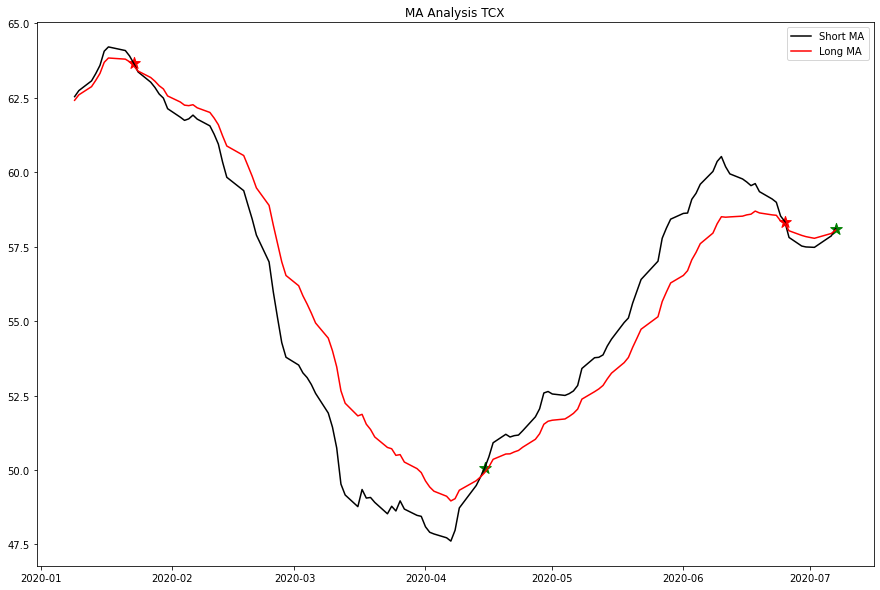

In [77]:

ticker='TCX'
start = '2020-01-01'
SDOW = generate_stock_data(start,now,ticker)




plt.figure(figsize=(15,10))
plt.plot(SDOW['Date'],SDOW['12Day_Moving_Average_Close'],label='Short MA',color='k')
plt.plot(SDOW['Date'],SDOW['26Day_Moving_Average_Close'],label='Long MA',color='r')


for values in range(len(SDOW)):
    if values!=0:
        if SDOW['MACD'].iloc[values]<0:
            if SDOW['MACD'].iloc[values-1]>0:
                plt.scatter(SDOW['Date'].iloc[values-1],SDOW['12Day_Moving_Average_Close'].iloc[values-1],marker='*',
                       color='red',s=150)
                
    if SDOW['MACD'].iloc[values]>=0:
        if SDOW['MACD'].iloc[values-1]<0:
            plt.scatter(SDOW['Date'].iloc[values],SDOW['12Day_Moving_Average_Close'].iloc[values],marker='*',
                       color='green',s=150)
            
            
plt.title('MA Analysis {}'.format(ticker))

plt.legend()
plt.show()

#### red star siginal a downward trend & green stars signal an upward trend

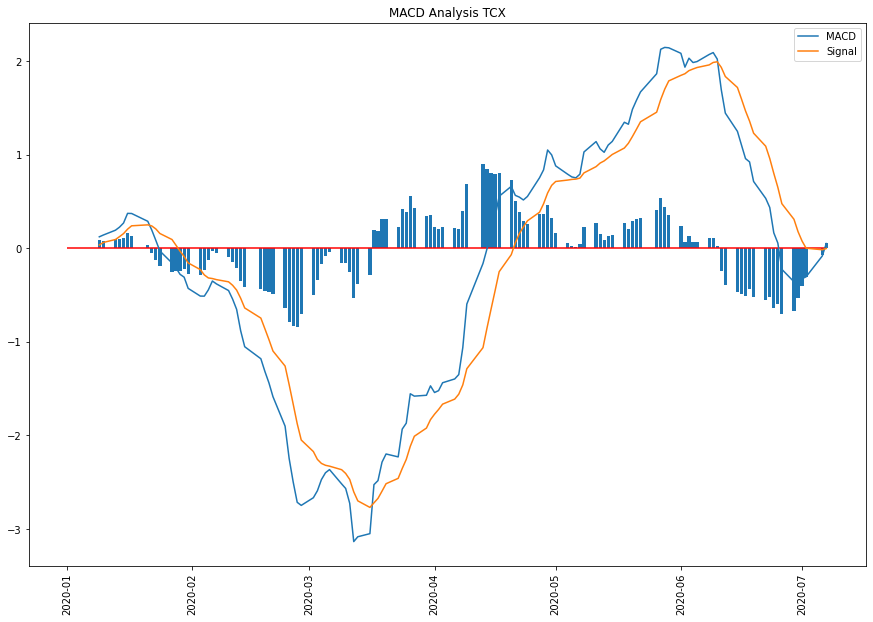

In [78]:
plt.figure(figsize=(15,10))
plt.title('MACD Analysis {}'.format(ticker))
plt.plot(SDOW['Date'],SDOW['MACD'],label='MACD')
plt.plot(SDOW['Date'],SDOW['signal'],label='Signal')
plt.hlines(0,start,now,'r')
plt.bar(SDOW['Date'],SDOW['hist'])
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [ ]:
min_by_min = get_quote_data_by_minute(symbol="WORK",data_range='1d', data_interval='1m')
min_by_min.tail(20)

In [ ]:
# For data manipulation
import pandas as pd

# To extract fundamental data
from bs4 import BeautifulSoup as bs
import requests

In [ ]:
TopShifts_up.head()

In [62]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers =list(np.unique(TopShifts_up['ticker']))
results = {}

with requests.Session() as s:

    for ticker in tickers:
        try:
            r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
            data = json.loads(p.findall(r.text)[0])
            key_stats = data['context']['dispatcher']['stores']['QuoteSummaryStore']
            results.setdefault(ticker,[])
            results[ticker]

            try:
                res = {'EnterPrise Value' :key_stats['defaultKeyStatistics']['enterpriseValue']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({'EnterPrise Value':np.nan})

            try:
                res = {'Trailing P/E' : key_stats['summaryDetail']['trailingPE']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({'Trailing P/E':np.nan})

            try:
                res = {'Forward P/E' : key_stats['summaryDetail']['forwardPE']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({'Forward P/E':np.nan})


            try:
                res = {'PEG Ratio (5 yr expected)' : key_stats['defaultKeyStatistics']['pegRatio']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({'PEG Ratio (5 yr expected)':np.nan})

            try:
                res = {'Return on Assets' : key_stats['financialData']['returnOnAssets']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({"Return on Assets":np.nan})

            try:
                res = {'Quarterly Revenue Growth' : key_stats['financialData']['revenueGrowth']['fmt']}
                results[ticker].append(res)
            except:
                results[ticker].append({"Quarterly Revenue Growth":np.nan})

            res = {'Company' : ticker}
            results[ticker].append(res)    
        except:
            pass



In [63]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers =list(np.unique(TopShifts_up['ticker']))
q_results = {}
main_keys = ['trailingPsRatio', 
             'quarterlyPbRatio', 
             'quarterlyForwardPeRatio',
             'quarterlyMarketCap', 
             'quarterlyPeRatio', 
             'trailingMarketCap',
             'trailingEnterprisesValueEBITDARatio',
             'quarterlyEnterprisesValueEBITDARatio', 
             'trailingForwardPeRatio', 
             'trailingEnterpriseValue',
             'trailingPeRatio', 
             'quarterlyEnterprisesValueRevenueRatio', 
             'quarterlyPsRatio', 
             'trailingEnterprisesValueRevenueRatio', 
             'quarterlyPegRatio', 
             'trailingPbRatio',
             'quarterlyEnterpriseValue', 
             'trailingPegRatio', 
             'timestamp']

with requests.Session() as s:

    for ticker in tickers:
        try:
            r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
            data = json.loads(p.findall(r.text)[0])

            key_stats = data['context']['dispatcher']['stores']['QuoteTimeSeriesStore']

            q_results.setdefault(ticker,[])
            for mk in main_keys:
                try:
                    res = {mk: key_stats['timeSeries'][mk][1]['reportedValue']['raw']}

                    q_results[ticker].append(res)
                except:
                    q_results[ticker].append({mk:np.nan})

            res = {'Company' : ticker}
            q_results[ticker].append(res)  
        except:
            pass
            
                
                
                
        

In [64]:
finstats = {}

for k in results.keys():
    c = results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats.setdefault(key,[])
            finstats[key].append(val)
    
            

In [65]:
fstat = pd.DataFrame(finstats)

In [66]:
finstats_q = {}

for k in q_results.keys():
    c = q_results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats_q.setdefault(key,[])
            finstats_q[key].append(val)
    

In [67]:
fstatsq = pd.DataFrame(finstats_q)

In [68]:
full_df = pd.merge(fstat,fstatsq,on='Company')
full_df_transpose=full_df.T
full_df_transpose.columns = list(full_df['Company'])

In [69]:
full_df_transpose=full_df_transpose.T
full

<function numpy.full(shape, fill_value, dtype=None, order='C')>

In [81]:
test = pd.merge(TopShifts_up,full_df_transpose,left_on='ticker',right_index=True)

In [83]:
add_meta = test[['Date', 'ticker', 'MACD', 'signal', 'Close', 'Upward', 'Day',
       'EnterPrise Value', 'Trailing P/E', 'Forward P/E','Return on Assets']]

In [86]:
add_meta.to_csv('/Users/sheenmccullough/Documents/StockEval/data/withMeta.csv',index=False)

In [89]:
add_meta

,Date,ticker,MACD,signal,Close,Upward,Day,EnterPrise Value,Trailing P/E,Forward P/E,Return on Assets
0,2020-07-07,ADTN,0.000779,0.007934,11.020000,1,1 Days Ago,469.29M,NaN,58.00,-3.48%
1,2020-07-07,AMCF,0.000027,-0.000258,0.009800,1,1 Days Ago,158.72M,NaN,NaN,3.78%
2,2020-07-07,ASTI,0.000003,-0.000002,0.000200,1,1 Days Ago,17.03M,NaN,-0.00,-39.21%
3,2020-07-07,BRID,0.001863,-0.113188,16.400000,1,1 Days Ago,175.01M,31.09,NaN,2.65%
4,2020-07-07,CERN,0.020708,-0.014617,70.080002,1,1 Days Ago,22.71B,43.63,21.17,6.44%
5,2020-07-07,DWSN,0.001792,0.014218,1.530000,1,1 Days Ago,18.29M,NaN,-3.08,-6.36%
6,2020-07-07,ECTE,0.000213,0.000156,0.013300,1,1 Days Ago,3.52M,NaN,NaN,-359.77%
8,2020-07-07,GROW,0.025594,0.020614,2.490000,1,1 Days Ago,27.33M,NaN,NaN,-9.68%
9,2020-07-07,HNNA,0.012525,0.032058,8.240000,1,1 Days Ago,51.28M,6.33,12.92,8.77%
10,2020-07-07,MACK,0.008031,-0.017965,3.510000,1,1 Days Ago,28.94M,NaN,-1.97,-19.15%
